# PART 2. Time Series Analysis

### 2.1 Calculate Produced Energy and Capacity Factor
In this part we calculate three quantities to be analysed as a funciton of the time:

- The **Average Energy** can be calculated from the average Active Power (P_avg, in kW)
- The **Produced Energy** is the integral over time of the average energy
- The **Capacity Factor** is the ratio of the real power output and nominal rated power

### 2.2 Test several Auto-Regression analysis
- Auto-Regression: What if we could just find a stationary explaination for the data series?

In [1]:
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%load_ext autotime

time: 385 µs (started: 2024-04-11 23:18:10 +02:00)


In [2]:
from windml.core.functions import load_all
data_dir = Path.cwd().parent.parent / 'Data Turbines - enriched'
df = load_all(data_dir)

Loading time: 7.84 seconds.
Memory usage: 262.31 MB.
1045835 Lines found.
time: 19 s (started: 2024-04-11 23:18:10 +02:00)


In [3]:
df['E_avg'] = df['P_avg'] / 6000 # from kW to MWh

P_nom = 2050 # kW | nominal power
df['CF_avg'] = df['P_avg'] / P_nom 

monthly_df = pd.DataFrame(df.groupby(['Year', 'Month'])[['P_avg', 'E_avg', 'CF_avg']].apply(lambda x : x.sum()))
monthly_df.reset_index(inplace=True)

time: 301 ms (started: 2024-04-11 23:18:29 +02:00)


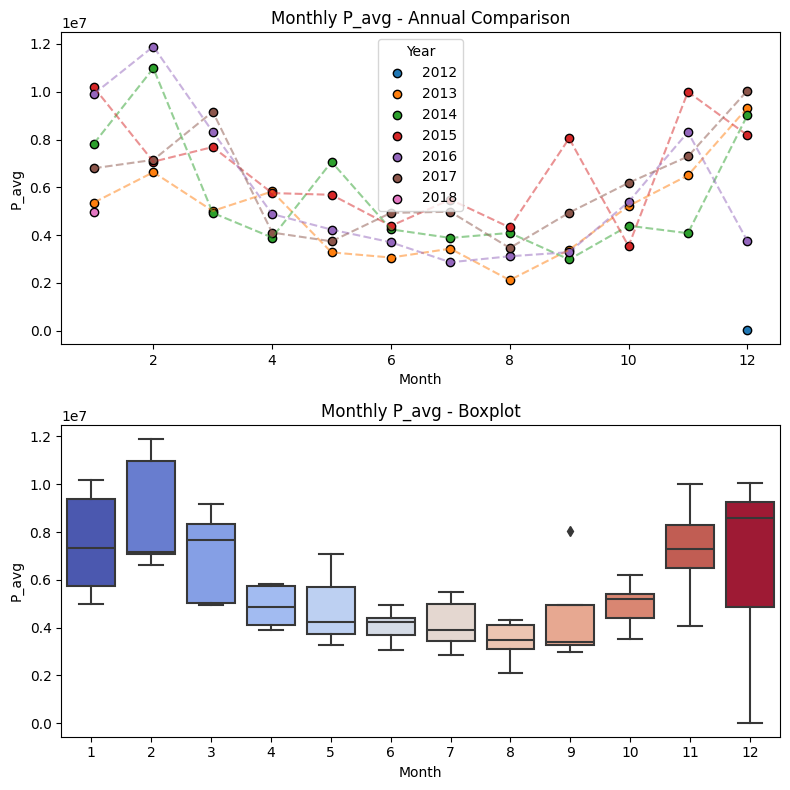

time: 1.13 s (started: 2024-04-11 23:18:30 +02:00)


In [4]:
from windml.visualization import custom_plots

custom_plots.plot_monthly_evolution(monthly_df, value_col='P_avg')
#custom_plots.plot_monthly_evolution(monthly_df, value_col='E_avg')
#custom_plots.plot_monthly_evolution(monthly_df, value_col='CF_avg')


## Auto-Regression Algorithm

### Comment

It is important to note that ```statsmodels``` is not directly compatible with ```scikit-learn```'s pipeline structure (eg ```Pipeline``` and ```GridSearchCV```), since it does not implement the ```fit``` and ```predict``` methods in the way scikit-learn expects.

One can create a custom wrapper for the ARIMA model that adheres to scikit-learn's interface, and then use GridSearchCV or similar tools for parameter tuning.

Mean Absolute Error (MAE): 291.06713290889434
Mean Absolute Error (MAE): 267.38034867764384
Mean Absolute Error (MAE): 275.8761545081877
Mean Absolute Error (MAE): 312.90733468234737


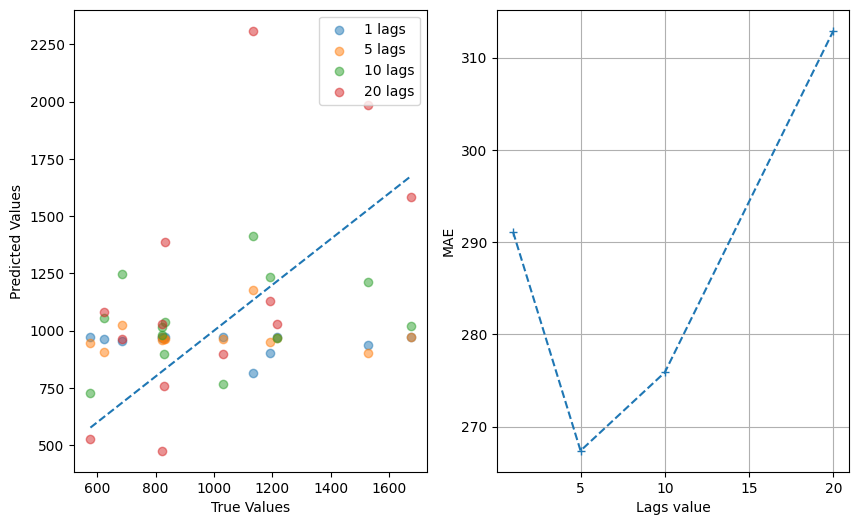

time: 2 s (started: 2024-04-11 23:18:31 +02:00)


In [5]:
import numpy as np
from windml.machine_learning.time_analysis import ar_forecast
from sklearn.metrics import mean_absolute_error

fig, ax = plt.subplots(1, 2, figsize=(10, 6))

mae_list = []
lags_list = [1, 5, 10, 20]

for lags in lags_list:
    
    forecast_df = ar_forecast(monthly_df, 'E_avg', lags=lags)
    merged_df = pd.merge(monthly_df, forecast_df, on=['Year', 'Month'], how='inner')
    
    mae = mean_absolute_error(merged_df['E_avg'], merged_df['pred_E_avg'])
    mae_list.append(mae)
    ax[0].scatter(merged_df['E_avg'], merged_df['pred_E_avg'], alpha=0.5, label=f'{lags} lags')
    print(f"Mean Absolute Error (MAE): {mae}")

ax[0].set_xlabel('True Values')
ax[0].set_ylabel('Predicted Values')
ax[0].legend()

xx = np.linspace(merged_df['E_avg'].min(),merged_df['E_avg'].max())
ax[0].plot(xx, xx, ls='--')

ax[1].plot(lags_list, mae_list, '+', ls = '--')
ax[1].set_xlabel('Lags value')
ax[1].set_ylabel('MAE')

plt.grid(True)
plt.show()


## Regularizing gradient boosting framework with xgboost

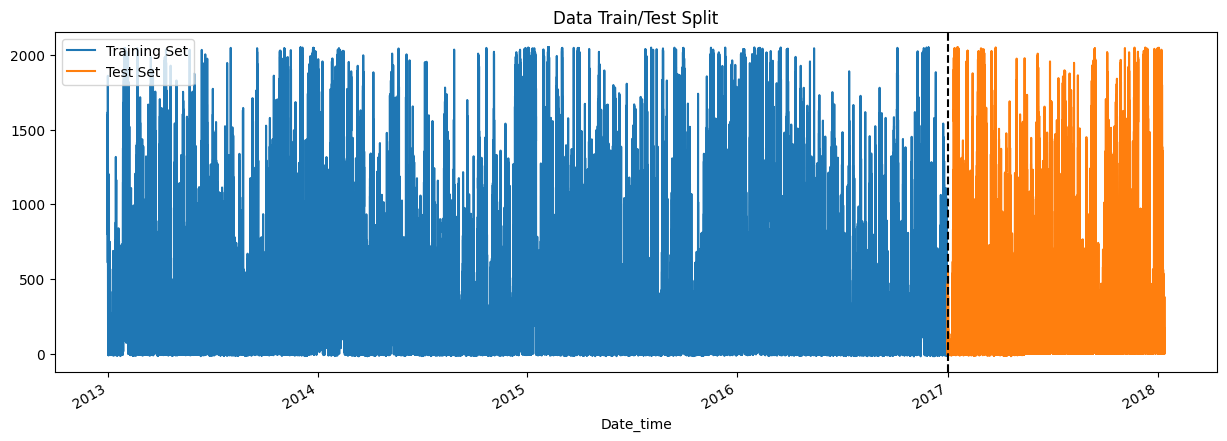

time: 29.3 s (started: 2024-04-11 23:18:33 +02:00)


In [6]:
split_date = '01-01-2017'
train = df.loc[ df.index < split_date ]
test = df.loc[ df.index >= split_date ]


fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', y='P_avg')
test.plot(ax=ax, label='Test Set', y='P_avg')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [7]:
y_variable = 'P_avg'
x_list = [ 'Ws_avg', 'Rs_avg', 'Yt_avg', 'Ba_avg' ]
x_list = [ 'Year', 'Month', 'DayOfWeek', 'HourOfDay']

X_train = train[x_list]
y_train = train[y_variable]

X_test = test[x_list]
y_test = test[y_variable]

time: 53.1 ms (started: 2024-04-11 23:19:02 +02:00)


In [8]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

time: 988 ms (started: 2024-04-11 23:19:02 +02:00)


In [11]:
# Simple estimator, with 1000 trees
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:409.20960	validation_1-rmse:458.66022
[100]	validation_0-rmse:369.65767	validation_1-rmse:493.65903
[200]	validation_0-rmse:366.76627	validation_1-rmse:497.98477
[300]	validation_0-rmse:365.54244	validation_1-rmse:499.34019
[400]	validation_0-rmse:364.85573	validation_1-rmse:500.27155
[500]	validation_0-rmse:364.39668	validation_1-rmse:501.00170
[600]	validation_0-rmse:364.08049	validation_1-rmse:501.45217
[700]	validation_0-rmse:363.85726	validation_1-rmse:501.67269
[800]	validation_0-rmse:363.67032	validation_1-rmse:501.74178
[900]	validation_0-rmse:363.52584	validation_1-rmse:501.90939
[999]	validation_0-rmse:363.41345	validation_1-rmse:502.11559


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

time: 1min 58s (started: 2024-04-11 23:21:16 +02:00)


In [12]:
reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:535.55206	validation_1-rmse:587.36995


[100]	validation_0-rmse:426.53352	validation_1-rmse:476.04502
[200]	validation_0-rmse:407.59397	validation_1-rmse:459.19849
[300]	validation_0-rmse:403.45323	validation_1-rmse:457.53395
[350]	validation_0-rmse:402.58633	validation_1-rmse:457.78923


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

time: 27 s (started: 2024-04-11 23:23:45 +02:00)


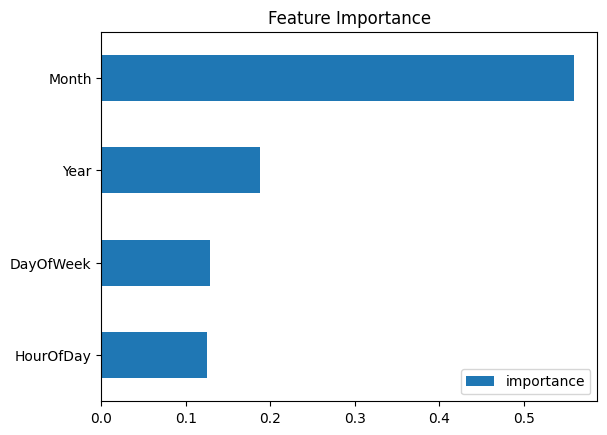

time: 382 ms (started: 2024-04-11 23:24:41 +02:00)


In [13]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

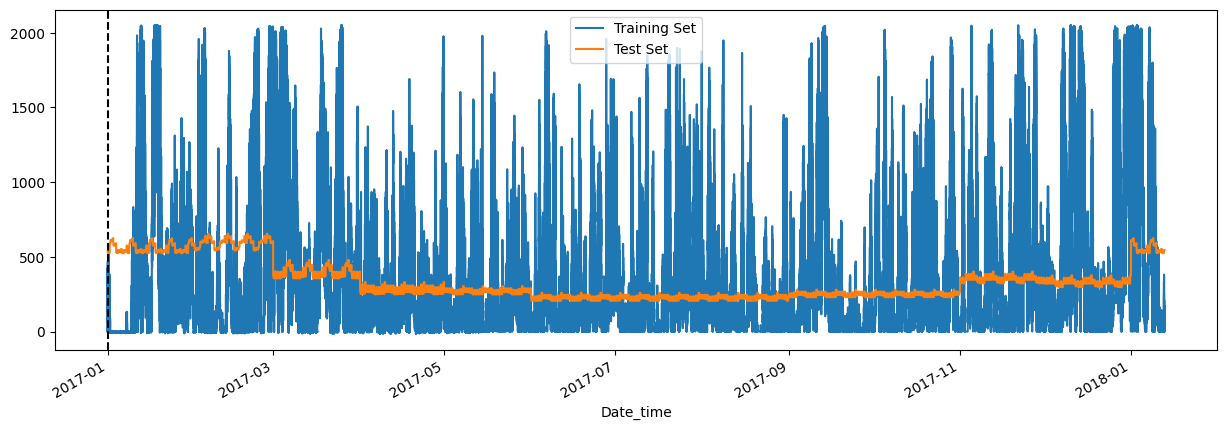

time: 12.4 s (started: 2024-04-11 23:31:14 +02:00)


In [24]:
test['prediction'] = reg.predict(X_test)

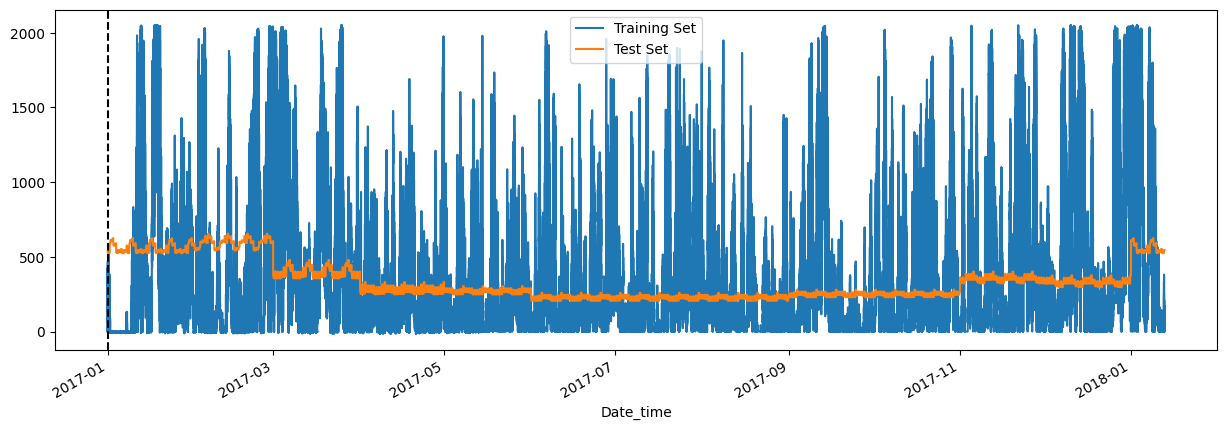

time: 10.7 s (started: 2024-04-11 23:33:54 +02:00)


In [28]:
fig, ax = plt.subplots(figsize=(15, 5))
test.plot(ax=ax, label='True', y='P_avg')
test.plot(ax=ax, label='Pred', y='prediction')
ax.axvline(split_date, color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
fig.savefig('XGBR.jpeg')
plt.show()

In [27]:
score = np.sqrt(mean_squared_error(test['P_avg'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')


RMSE Score on Test set: 457.53
time: 46.9 ms (started: 2024-04-11 23:32:04 +02:00)
